In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('default')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13874501279484417322
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3667263488
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16808687004216672388
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 합성곱 신경망을 이용한 컴퓨터 비전
컴퓨터 비전뿐만 아니라, 음성 인식과 자연어 처리에도 이용되는 합성곱 신경망.<br>
되게 공부는 예전에도 했었지만 한번 더 깊게 공부해보자.<br>

## 시각 피질 구조
우리의 시각 뉴런은 시야 전체가 아닌 일부 범위 안에 있는 시각 자극에만 반응한다.<br>
또한 모든 자극이 아닌 특정 자극 (예를 들면 수평, 수직 선분) 에만 반응하며 <br>
이런 낮은 수준의 패턴이 조합된 고수준의 패턴에 반응하는 뉴런또한 존재한다.<br>
이런 관찰은 고수준 뉴런이 이웃한 저수준 뉴런의 출력값에만 반응한다는 사실을 유도해냈고<br>
이를 구현한 ***합성곱 신경망*** 이 1998년 얀 르쿤 등의 LeNet-5 구조부터 각광받기 시작했다.<br>

## 합성곱 층
합성곱 층의 뉴런은 시각 피질 뉴런과 마찬가지로 이전 뉴런(혹은 입력 이미지)의 모든 픽셀에 연결되지 않고,<br>
합성곱 층 뉴런의 수용장(범위) 안에 있는 픽셀에만 반응하고 연결된다. 이런 뉴런들이 계속해서 이어지며  
실제 시각 피질구조와 유사한 구조를 가지게 되고 하위 층일수록 저수준 특성에, 상위 층일수록 고수준 특성에 집중하며
<br>
계층적 구조를 형성하게 되고 이는 실제 이미지에서 흔히 볼 수 있는 구조이어서 CNN이 이미지 인식에서 잘 작동한다.
<br><br>
여기에서 설명한 이외의 Conv layer들에대한 설명 : https://eehoeskrap.tistory.com/431
### 패딩
이렇게 계층적 구조를 쌓다보면 점점 상위 층으로 갈수록 압축되어 줄어들게 된다.  
즉 다음 층의 (i,j)에 위치한 하나의 뉴런은 이전의 뉴런의 수용장에 위치한 뉴런과 연결되면서 점점 크기가 작아진다.<br>
만약 층의 높이와 너비를 유지하고 싶다면 입력의 주위에 0을 추가하는 제로 패딩이 이용된다.
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbuF4ft%2FbtqJZnrRhL0%2FXsApi9EoBjtjwSOkx9KLEk%2Fimg.png" width="500px">
<br>
보통 padding 파라미터에 "VALID"를 넣으면 패딩이 없다. (수용장이 입력을 안벗어나서 dropped value가 생긴다)  
하지만 "SAME"을 주면 패딩이 필요한 경우 추가되고 스트라이드가 1이라면 입력과 출력의 크기가 같아진다.  
<img src="https://www.tutorialexample.com/wp-content/uploads/2020/08/Understand-the-Difference-Between-SAME-and-VALID-Padding-in-Convolution-Networks.png">
### 스트라이드
만약 수용장 사이에 간격을 두어 큰 입력층을 훨씬 작응 층에 연결하는 것이 가능하다. 이런 간격을 ***스트라이드*** 라고 한다. <br>
상위층의 $(i,j)$에 있는 뉴런은 이전 층의 $(i*s_h:i*s_h+f_h\;,\;j*s_w:j*s_w+f_w)$ 에 위치한<br>
뉴런들과 연결되며 이때 $s_h\;와\;s_w$ 는 스트라이드의 수직, 수평 값이다.
<img src="https://csdl-images.ieeecomputer.org/trans/si/2020/04/figures/ko1ab-2961602.gif" width="500px">
<br>
### 필터
conv layer에서 뉴런의 가중치는 수용장 크기의 작은 이미지, 즉 ***필터 (또는 합성곱 커널)*** 이 된다.<br>
해당 필터를 통과한 입력값 (이미지)은 필터를 가장 크게 활성화 시키는 이미지의 영역이 강조된 하나의 ***특성 맵*** 을 만든다.<br>
<img src = "https://miro.medium.com/max/1400/1*n2EW3EWHhvQ26z60HKRhvg.png" width="500px"><br>
수동으로 필터를 정의하지 않아도 전체 신경망이 훈련하는 동안 문제에 가장 최적화된 필터를 찾고 상위 층과 연결되어  <br>더 복잡하고 추상적인 패턴을 학습할 수 있도록 도와준다.

### 풀링
CNN이 FC layer보다 적은 양의 메모리를 요구하긴 하지만 여전히 많은 양의 메모리를 필요로 한다.  
게다가 이미지 크기가 클수록 파라미터의 크기가 늘어나기에 과대적합의 위험성 또한 늘어난다.  
이를 위해 이미지를 줄여주는, 즉 축소본을 만드는 ***풀링*** 작업이 필요하다.  
#### 최대 풀링 (max pooling)
conv layer와 마찬가지로 풀링 층의 각 뉴런은 이전 층의 사각 영역의 수용장에 있는 뉴런과 연결된다.  
다만 차이라면 최대 풀링 층은 수용장에서 가장 큰 값만 들고 와서 현재 층에 전달시켜준다.
<img src="http://computing.or.kr/wp-content/uploads/2020/07/234.png">
<br>
뿐만 아니라 최대 풀링은 지역적인 특성을 뽑아내기에 일정 수준의 ***불변성(invariance)*** 를 만들어준다.<br>
<img src="https://i.ibb.co/P5vN9vD/Captura9.png" width="500px">
<br>
사진에서도 보이듯이 A와 B는 아예 같고, B와 C는 50%가 일치하게 된다.<br>
다만 단점으로 입력값을 엄청나게 줄이기 때문에 정보를 잃게 된다. 그리고 어떤 경우에는 불변성이 필요없는 경우가 있다!<br>
예를 들어 입력 이미지의 이동에 따라 결과 값 또한 같이 이동해야 하는 경우,  
***등변성(equivariance)*** 이 목표가 되기에 불변성이 필요 없다.

```python
max_pool = keras.layers.MaxPool2D(pool_size=2)
```

#### 평균 풀링 (avg pooling)
최대 풀링과 유사하게 이 층은 최댓값이 아닌 평균을 계산하여 다음 층에 넘겨준다. <br>
정보 손실량이 최대 풀링과 적긴 하지만 최대 풀링은 큰 특징만 유지해서 다음 층이 좀 더 명확한 신호로 작업할 수 있다.  
실제로 최대 풀링이 성능이 일반적으로 더 좋아서 잘 사용하진 않는다.
```python
avg_pool = keras.layers.AvgPool2D(pool_size=2)
```

#### 깊이 차원으로의 풀링
동일 패턴이 회전된 여러 필터가 학습되었다면 깊이 방향 최대 풀링은 회전에 상관없이 동일한 출력을 만든다.<br>
회전 뿐만 아니라 두께, 밝기, 왜곡 색상과 같이 어떤 것에 대해서도 불변성을 학습할 수 있다.<br>
<img src = "https://i.ibb.co/zZkmsHy/deph-wise-max-pool.png" width="500px">
<br>
케라스에는 구현되어 있지 않지만 저수준 API로 구현이 가능하다.
```python
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), 
                             strides=(1, 1, 1, 3), padding="VALID"))
```
(커널 크기와 스트라이드를 깊이 차원을 따라 가도록 지정해주는 것이다)
#### 전역 평균 풀링 층
각 특성 맵의 평균을 계산해주는 층이다. 말 그대로 하나의 특성 맵이 하나의 숫자를 출력하게 된다. <br>
많은 정보를 잃게 되지만 출력층에는 유용할 수 있다.
```python
global_avg_pool = keras.layers.GlobalAvgPool2D()

# 또는 tf.reduce_mean을 이용하여 모든 행과 열을 따라 평균 값을 계산할 수 있다. 
global_avg_pool = keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1,2]))
```
### 특성 맵 쌓아 올리기
실제 합성곱 층은 여러 필터를 사용하고 필터마다 하나의 특성 맵을 출력한다.<br>
심지어 입력 이미지는 컬러 채널과 같이 하나의 층이 여러 서브 층으로 구성되기도 한다.<br>
다음 층의 하나의 특성맵은 이전 층의 모든 채널의 특성맵에서 수용장에 위치한 뉴런의 출력과 연결된다.<br>
<img src="https://images.velog.io/images/cherria96/post/8fa14285-ad3d-418c-9fc8-ea7516abc866/KakaoTalk_20210329_220700478.jpg" width="500px"><br>
수식으로 나타내면 다음과 같다.
\begin{equation}
z_{i,j,k}\;=\;b_k\;+\;\sum_{u=0}^{f_h-1}\sum_{v=0}^{f_w-1}\sum_{k=0}^{f_n-1}\;
x_{i^{'},j^{'},k^{'} \; \bullet \; W_{u,v,k^{'},k}}\;\;
where
\begin{cases}
    i^{'}\;=\;i\bullet\; s_h\;=\;u\\
    j^{'}\;=\;j\bullet\; s_w\;=\;v
\end{cases}
\end{equation}
<br>
$z_{i,j,k}$에 위치한 뉴런의 출력은 이전 레이어의 모든 특성에서의 수용장 내 입력에 대한 가중치 합과 편향의 합임을 알 수 있다. <br>


## CNN 구조
전형적인 CNN 구조는 합성곱 층을 몇 개 쌓고 (각각 활성화 층을 그 뒤에 놓고),<br>
그 다음 풀링 계층을 쌓은 기본적인 구조를 일정 횟수 반복한다.<br>
네트워크를 통과하여 진행할수록 이미지가 점점 작아지지만, 합성곱 층 때문에 더 많은 특성맵을 가진다.<br>
맨 상위 층에는 몇 개의 FC layer로 구성된 신경망이 추가되고 마지막에 softmax를 통해 클래스 별 확률을 출력한다.<br>
<img src="https://velog.velcdn.com/images%2Fdltjrdud37%2Fpost%2Fc6c85370-639c-4261-8cef-f418226d66f5%2Fcnn_banner.png" width="700px"><br>
```python
# Conv layer로 이미지 크기를 줄이는 것이 아니라, 
# 크기가 2인 max pooling layer로 공간 차원을 절반으로 줄인다.

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3,
                        activation='relu',
                        padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, 
                  kernel_size=7, 
                  input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    
    # FC layer로 구성된 피드포워드 신경망 (순환되지 않는 구조)
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])
```
이미지 크기가 클수록 큰 필터를 이용하고 Conv-pooling 구조를 여러번 반복한다.
<br><br>
CNN이 출력층에 다다를수록 필터 개수가 증가한다. (점점 고수준 특성을 뽑아야하기에 이런 구조가 합리적이다).<br>
풀링 층 다음에서 필터 개수를 2배로 늘리는 것이 일반적인 방법이다. 풀링층이 공간 방향 차원을 줄여주기에<br>
파라미터 개수와 메모리, 계산 비용을 크게 늘리지 않고도 특성맵을 2배로 늘릴 수 있다!
<br><br>
이런 CNN의 기본적인 구조가 수년동안 다양한 변종이 나왔고 덕분에 ILSVRC와 같은 대회에서 에러율이 크게 감소했다.<br>
심지어 강아지 품종 (시베리안 허스키와 에스키모 개의 차이라던가)과 같이 구분하기 어려운 경우에도 좋은 성능을 보였다.
### LeNet-5 (1998)
얀 르쿤이 만든 잘 알려진 CNN 구조이다. MNIST에 널리 사용되었다.<br>
<img src="https://miro.medium.com/max/1200/1*y68ztClLF6ae7P53ayyFzQ.png" width="700px">
<br>
여기서 subsampling은 크기가 2인 avg pooling으로 진행된다. 다만 좀 특이한 부분이 좀 있는데,  
평균을 계산한 다음, 특성맵마다 하나씩 있고 학습되는 값인 계숫값을 곱하고 편향을 더해주고 tanh에 적용한다.
<br><br>
또한 마지막 출력층을 제외하고 모든 층들은 tanh 활성화 함수를 가지며 출력층은 RBF(방사 기저 함수)를 가진다.  
출력층에서는 입력 베터와 가중치 벡터 사이의 유클리드 거리를 출력한다.  
요즘엔 정확도를 올려주고 그레디언트가 빠르게 수렴되는 크로스 엔트로피 비용 함수를 선호한다.
### AlexNet (2012)
알렉스 크리체프스키가 만든 LeNet-5와 유사하지만 크고 더 깊은 신경망이다.<br>
다만 차이라면 처음으로 합성곱 위에 최대 풀링을 바로 쌓지 않고 합성곱을 더 쌓았다.<br>
<img src="http://www.eewebinar.co.kr/XILINX/images/edt/6RXZYPK5LI830OI2ZC4M.png" wdith="600px">
<br>
그리고 9번째, 10번째 FC layer에 50% 비율의 드롭아웃을 적용하고<br>
훈련 이미지를 랜덤하게 뒤집고 조명을 바꾸는 식으로 ***데이터 증식*** 을 수행하는 식으로 규제 기법을 적용했다.
<br><br>
또한 1, 3번째 Conv Layer의 ReLU 단계 이후에 바로 **LRN (Local Response Normalization)** 이라 불리는
<br>
경쟁적인 정규화 단계가 적용되었다. 가장 강하게 활성화된 뉴런이 다른 특성 맵에 있는 같은 위치의 뉴런을 억제한다.
<br>(실제로 생물학적 뉴런에서도 적용되는 방식이다)<br>
이는 특성맵끼리 중복되는 것을 막고, 더 넓은 시각에서 특징을 탐색하도록 만들어 일반화 성능의 향상을 이끈다.
<br><br>
\begin{equation}
b_i\;=\;a_i\;(k+\alpha\sum_{j=j_{low}}^{j_{high}}a_{j}^{2})^{-\beta}\quad where
    \begin{cases}
    j_{high}\;=\;min\;(i+\frac{r}{2},\;f_n-1)\\
    j_{low}\;=\;max\;(0,\;i-\frac{r}{2})
    \end{cases}
\end{equation}
<br>
여기서 $b_i$는 i번째 특성 맵의 정규화된 출력이고 $a_i$ 는 정규화 단계를 거치기 전의 뉴런의 활성화 값이다.  
$k, \alpha, \beta, r$ 은 하이퍼파라미터이고 $k$는 편향, $r$은 깊이 반경이라고 부른다.
```python
# LRN 단계는 이미 구현되어 있어서 이 함수를 Lambda layer로 감싸주면 된다
tf.nn.local_response_normalization()
```
### GoogLeNet (2014)
구글 리서치의 크릿스찬 세게디등이 개발하였으며 ILSVRC 2014 대회에서 톱-5 에러율을 7% 이하로 낮추었다.<br>
이전 CNN보다 깊은 구조 뿐만 아니라 인셉션 모듈이라는 서브 네트워크를 가짐으로써 파라미터를 효과적으로 사용한다.
<br><br>
*인셉션 모듈의 아이디어는 이 프로세스를 cross-channel correlation과 spatial correlation을  
독립적으로 살펴볼 수 있게 함으로써 이 프로세스를 좀더 쉽고 효율적으로 만든다는 것입니다.  
즉, 일반적인 인셉션 모델은 먼저 1x1 convolution을 통해 cross-channel correlation을 살펴보고,  
입력 데이터를 원래의 공간보다 작은 3, 4개의 별도 공간에 mapping 한 다음,  
이 작은 3D 공간의 모든 상관관계를 3x3, 5x5 convolution을 통해 mapping 합니다.*  
<br>

<img src="https://www.researchgate.net/profile/Bo-Zhao-67/publication/312515254/figure/fig3/AS:489373281067012@1493687090916/nception-module-of-GoogLeNet-This-figure-is-from-the-original-paper-10.png" width="600px">
<br>
모든 층의 활성화 함수는 ReLU이고, 두번째 층에서는 각기 다른 커널 크기를 통해 다른 크기의 패턴을 잡는다. <br>
모든 layer들은 스트라이드 1과 "same" 패딩을 사용하여 출력의 크기가 입력과 동일하다. <br>
이렇게 되면 모든 출력을 깊이 연결 층에서 깊이 방향으로 연결할 수 있다. <br><br>
또한 1x1 커널의 합성곱 층은 깊이 차원을 따라 놓인 패턴을 잡아주고 입력보다 더 적은 특성 맵을 출력해주기에<br>
차원을 줄여주는 병목 층 (bottleneck layer)의 역할을 담당해준다.<br>
또한 3x3, 5x5 크기의 합성곱 층과 연결되어 있어서 더 복잡한 패턴을 감지할 수 있는 한 개의 강력한 합성곱 층처럼 작동한다.<br>
<img src="https://miro.medium.com/max/1400/1*vM-p0R9SzTL1nDlb_-txjg.jpeg" width="600px"><br>
또한 중간중간에 보면 보조 분류기를 포함하고 있다. 여기서 발생한 손실의 30% 정도가 전체 손실에 더해진다.<br>
이는 그레디언트 소실문제를 줄이고 규제를 하기 위함이었지만 효과가 적은 것으로 알려져있다.

### ResNet (2015)
카이밍 허 등은 잔차 네트워크 (Residual Network)를 사용하여 2015년도 대회에서 우승했다.  
스킵 연결(혹은 숏컷 연결)은 훈련을 더 빠르게 만들어주고 수렴 난이도를 낮춰준다.  
신경망을 훈련시킬 때는 목적 함수 $h(x)$ 를 모델링하는 것이 목표이다. 만약 입력값인 $x$를  
네트워크의 출력에 더해준다면 $f(x)=h(x)-x$와 같이 $x$를 제외한 부분만 학습시키면 된다.  
<img src="https://neurohive.io/wp-content/uploads/2019/01/resnet-e1548261477164.png" width="600px"><br>
따라서 $f(x)$와 같이 $x$를 제외한 잔여 부분만을 학습을 진행하는데 이는 전체를 학습시키는 것보다 쉽다.  
더 나아가 잔차연결의 이점으로 일부 층이 학습되지 않았더라도 입력 신호가 네트워크 전체에 영향을 미친다.  
이는 그레디언트 소실 문제를 해결해주는 것으로 알려져있다.

### Xception (2016)
케라스의 창시자인 프랑수아 숄레가 제안했으며 대규모 비전문제에서 좋은 성능을 보였다.  
GoogLeNet과 ResNet의 아이디어를 합쳤으며 인셉션 모듈을 ***깊이별 분리 합성곱 층*** 으로 대체했다.  
<img src="https://wikidocs.net/images/page/164801/Fig_12.png" width="600px"><br>
기존의 합성곱 층은 **공간상의 패턴(직선, 타원 형태 등)** 과 **채널 사이의 패턴 (입, 코, 눈 = 얼굴)** 을  
필터를 이용하여 동시에 잡았다. 하지만 분리 합성곱 층은 이 둘을 분리하여 모델링 할 수 있음을 가정한다.  

우선 들어온 특성맵들에 대하여 깊이 필터(1x1)을 적용하여 특성맵을 줄여준다. **(Pointwise Conv)** <br>
(다만 이때 활성화 함수를 사용하지 않는다. 이 경우, 정보 손실이 발생하여 사용하지 않는 편이 더 낫다고 한다)<br>
그리고 공간 필터를 채널마다 단 한 개만 적용해주고 채널 사이의 패턴을 조사한다. **(Depthwise Conv)**<br>
입력 채널마다 하나의 공간 필터만 가지기에 채널이 너무 적은 층 다음에 사용하는 것을 피해야한다.<br>

### SENet (2017)
인셉션과 ResNet 구조를 확장시킨 SENet은 SE-Inception과 SE-ResNet을 가진다.  
원래 구조에 있던 모든 유닛에 SE 블록이라는 작은 신경망을 추가하여 성능을 향상 시켰다.  
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FpZvP2%2FbtqBEAqMq44%2FfQLZXp6PKydP0k1AoSfLG0%2Fimg.png" width="800px"><br>
SE 블록은 추가된 부분의 유닛의 출력을 깊이 차원에 중점을 두고 분석해준다 (공간은 상관X)  
(각 채널별로 전역 평균 풀링을 진행하여 1차원 배열로 만들어준다)  
즉, 어떤 특성이 가장 크게 활성화 되는지 학습해주고 이를 이용하여 특성 맵을 보정해준다.  
(예를 들어 특정 특성이 나오면 관련 있는 특성을 강화시키고, 관련 없는 특성을 줄여준다)  


## 케라스를 사용한 ResNet-34 CNN 구현
케라스의 유연성은 ResNet34와 같이 복잡한 모델도 짧은 코드로 구현할 수 있도록 해준다.<br>
물론 유명한 모델들은 이미 구현되어 잇어 사전훈련된 모델들로 불러 올 수 있다...

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3,
                        strides=1,
                        padding="SAME",
                        use_bias=False)


class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(), self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1: # 스킵 연결하는 경우 입력과 출력의 크기가 다른것을 해결해주기 위해 1x1 필터를 통과
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

## 케라스에서 제공하는 사전훈련된 모델
ResNet-34 같은 웰노운 모델들은 이미 keras.applications 패키지에 담겨있다. <br>
```python
# weights = "imagenet" 으로 이미지넷 데이터셋에서 훈련된 모델을 로드한다.
model = keras.applications.resnet50.ResNet50(weights="imagenet")
```

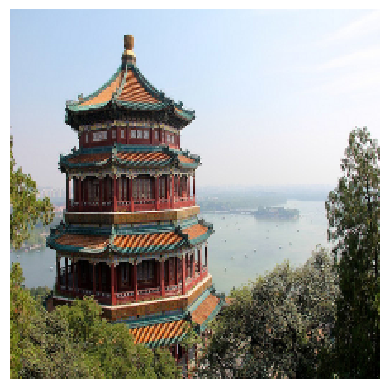

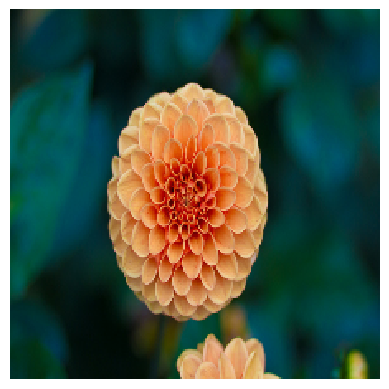

Image #0
  n02825657 - bell_cote    82.34%
  n03877845 - palace       6.76%
  n03781244 - monastery    4.19%
  n02980441 - castle       3.16%
  n03028079 - church       1.00%

Image #1
  n03530642 - honeycomb    49.78%
  n13040303 - stinkhorn    33.99%
  n02206856 - bee          4.35%
  n11939491 - daisy        3.23%
  n12985857 - coral_fungus 2.66%



In [11]:
import numpy as np
from sklearn.datasets import load_sample_image

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
keras.backend.clear_session()
model = keras.applications.resnet50.ResNet50(weights="imagenet")    
# 샘플 이미지를 로드합니다.
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
images_resized = tf.image.resize(images, [224, 224])

plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=5)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

## 사전 훈련된 모델을 사용한 전이 학습
훈련 데이터가 충분하지 않다면 사전 훈련된 모델의 하위층을 사용하는 것이 효율적이다.<br>
이를 구현하기 위하여 Xception 모델을 사용해 꽃 이미지를 분류하는 모델을 만들어보자  
요 아래는 데이터를 불러오고 전처리하는 단계이다.

In [4]:
keras.backend.clear_session()

import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy"...]
n_classes = info.features["label"].num_classes # 5

In [5]:
# 책과 다른부분. split API가 개편되었다.
# https://www.tensorflow.org/datasets/splits

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [6]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

조금 더 정교한 전처리를 원한다면 아래 코드 실행
```python
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)
```
전처리가 끝났으니 이제 모델을 생성하자.  
xception 모델을 base_model로 하고 include_top을 False로 두어 최상위 층의 전역평균풀링과 Dense층을 뺀다.  
그리고 새롭게 훈련시킬 전역평균풀링층과 미리 정한 클래스 만큼의 softmax 출력층을 붙인다.

In [7]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [12]:
# 사전 훈련된 층의 가중치는 동결해놓자
for layer in base_model.layers:
    layer.trainable = False
    
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
# 라벨이 int 형태로 주어지므로 sparse categorical crossentropy 를 이용한다.
# 라벨이 원핫 인코딩 되어 있다면 categorical crossentropy를 사용하면 된다.
# (둘이 비슷하게 작동하지만 라벨의 종류에 따라 결정하는 것)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics="accuracy")
history = model.fit(train_set,
                    epochs=5,
                    validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 10s 96ms/step - loss: 0.0297 - accuracy: 0.9898 - val_loss: 0.7538 - val_accuracy: 0.8766
Epoch 2/5
30/86 [=========>....................] - ETA: 4s - loss: 0.0257 - accuracy: 0.9906

KeyboardInterrupt: 

이 과정을 걸치고 나면 추가된 최상위 층들의 훈련이 완료된다.  
이제 모든 층의 동결을 해제하고 훈련을 계속한다. (층을 동결하고 해제할 때 컴파일을 꼭 진행하자)  
다만 사전 훈련된 층의 가중치가 심하게 훼손되는 것을 막기 위하여 작은 학습률을 이용한다.

In [11]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics="accuracy")
history = model.fit(train_set,
                    epochs=5,
                    validation_data=valid_set,
                    batch_size=1)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block9_sepconv1/separable_conv2d' defined at (most recent call last):
    File "C:\Users\hesh0\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\hesh0\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\hesh0\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\hesh0\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\hesh0\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\hesh0\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\hesh0\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\hesh0\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\hesh0\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\hesh0\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\hesh0\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "C:\Users\hesh0\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\hesh0\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\hesh0\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\hesh0\AppData\Local\Temp\ipykernel_12264\1044355669.py", line 11, in <cell line: 11>
      history = model.fit(train_set,
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\hesh0\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 2255, in call
      outputs = tf.compat.v1.nn.separable_conv2d(
Node: 'model/block9_sepconv1/separable_conv2d'
OOM when allocating tensor with shape[32,728,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block9_sepconv1/separable_conv2d}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_30076]

## 분류와 위치 추정
물체의 위치를 추정하는 작업은 회귀 작업의 일종으로 나타낼 수 있다.  
즉 물체 주위에 바운딩 박스를 예측하기 위하여 물체 중심의 수평, 수직 좌표와 높이, 너비를 예측해야 한다.  
이 4가지 숫자를 예측하기 위하여 모델을 전부 바꾸기 보단  
마지막에 4개의 유닛을 가진 밀집 출력 층을 추가하고 MSE를 사용하여 훈련한다.  

In [13]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# 클래스 별 확률을 출력
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)

# 물체의 위치를 출력
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(
    loss=["sparse_categorical_crossentropy", "mse"],
    loss_weights=[0.8, 0.2],  # 어떤 것을 중요하게 생각하느냐에 따라
    optimizer=optimizer,
    metrics=["acc"])


def add_random_bounding_boxes(images, labels):
    fake_boxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_boxes)


fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, steps_per_epoch=5, batch_size=2, epochs=2)

NameError: name 'optimizer' is not defined

다만 코드에서 보이듯이 꽃의 데이터셋은 바운딩 박스가 따로 없기 대문에 직접 추가해야 한다.  
이처럼 레이블을 직접 만드는 것은 가장 어렵고 비용이 많이 드는 작업중 하나이다.  
<br>
일단 모든 주어진 데이터에 가짜 바운딩 박스 레이블를 생성하고 (image, (class_labels, bounding_boxes))
<br> 형태의 튜플로 데이터셋을 넘겨준다.  
<br>
그리고 바운딩 박스의 모든 값들의 범위는 [0,1] 사이로 정규화 시켜야한다.  
또한 제곱근 값을 예측하므로 작은 바운딩 박스에서 오차가 클수록 패널티가 커진다.  
<br>
그리고 MSE보다 바운딩 박스에서 널리 사용되는 Intersection over Union (IoU) 지표가 있다.  
IoU는 바운딩 박스와 타깃 바운딩 박스 사이에 중첩되는 교집합 영역을 합집합 영역으로 나눈 값이다.
```python
tf.keras.metrics.MeanIoU
```

## 객체 탐지
하나의 이미지에 여러 물체가 담겨있을 경우, 각각의 물체를 분류하고 위치를 추정하는 작업을 ***객체 탐지*** 라고 한다.<br>
이미지를 grid로 나누고 일정한 크기에 대하여 CNN을 적용시키며 모든 영역들을 지나간다. <br>
또한 객체 크기가 다르기 때문에 크기를 바꿔나가면서 슬라이딩할 수 있다.  
이렇게 되면 불필요하거나 겹치는 부분이 발생하는데 우선 두가지 방법이 있다.
1. 먼저 CNN에 해당 객체가 존재하는 지 여부를 sigmoid로 확률을 얻어내고 일정 이하를 삭제한다.<br>
2. 그리고 겹치는 박스중에서 확률이 가장 높은 박스만 남기고 삭제한다.

이 방식이 잘 작동하지만, CNN을 많이 실행시켜야 하므로 느린면이 있다.  

### 완전 합성곱 신경망 (FCN)
2015년 조너선 롱 등이 ***시멘틱 분할 (물체가 속한 클래스에 따라 이미지의 모든 픽셀을 분류하는 작업)*** 을 위해<br>
제시한 방법이며 CNN의 상위에 있는 FC layer를 Conv layer로 바꿀 수 있다고 주장했다.
기존 방식대로 FC layer 출력층을 이용하면 전체 이미지에 대한 클래스를 출력할 수는 있어도,  
위치 정보를 잃기 때문에 그 물체가 어디에 존재하는 지를 알 수 없었다.  
하지만 Conv layer로 이를 대체하면 위치정보를 유지한채로 각 픽셀에 대한 정보를 뽑을 수 있다.  
만약 필터의 개수가 10개라면 0~4까지 각 클래스에 대한 확률을, 5번째 특성맵에는 존재 확률을, 나머지에는  
바운딩 박스의 좌표와 높이, 너비를 담을 수 있다!  
이는 하나의 CNN을 슬라이딩하는 것과 똑같은 효과를 가지지만 전체 이미지를 단 한번만 처리하기에 효율적이다.  
이를 ***You Only Look Once (YOLO)*** 방식이라고 하여 유명한 객체 탐지 방법이다.

### YOLO
